### Gene expression vs 3D changes during Legionella infection
**cmdoret**


In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. 

In [2]:
import os
os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import scipy.stats as ss

diff_expr = pd.read_csv('data/output/diff_expr/c3_diff_expr.tsv', sep='\t')
diff_expr = diff_expr.reset_index(drop=False)
diff_expr = diff_expr.rename(columns={'index': 'accession'})
# Load relevant columns from annotation file and select mRNA only
annot = (
    pd.read_csv(
        'data/input/annotations/c3_annotations/Acanthamoeba_castellanii_C3.gff3',
        sep='\t',
        comment='#',
        header=None,
        usecols=[0, 2, 3, 4, 8],
        names=['chrom', 'type', 'start', 'end', 'attr'])
    .query('type=="mRNA"')
)
annot['accession'] = annot['attr'].str.replace(r'ID=([^;]*)\.mRNA\.[0-9]+;.*', r'\1')
# For each gene, retain only the longest transcript (to remove redundancy)
annot['length']= annot['end'] - annot['start']
annot = (
    annot
    .sort_values('length', )
    .groupby('accession')
    .head(1)
    .sort_values(['chrom', 'start', 'end'])
    .reset_index(drop=True)
)
# Extract functinoal annotations as individual columns
annot['desc'] = annot['attr'].str.replace(r'.*product=([^;]*);.*', r'\1')
annot['IPR'] = annot['attr'].apply(lambda s: re.findall(r'InterPro:(IPR[0-9]+)', s))
annot['PFAM'] = annot['attr'].apply(lambda s: re.findall(r'PFAM:(PF[0-9]+)', s))
#annot[['IPR', 'PFAM']] = annot[['IPR', 'PFAM']].applymap(lambda l: l if len(l) else np.nan)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The default value of regex will change from True to False in a future version.


In [4]:
annot

,chrom,type,start,end,attr,accession,length,desc,IPR,PFAM
0,scaffold_1,mRNA,504,5457,ID=VMHBD_00001.mRNA.1;Parent=VMHBD_00001;produ...,VMHBD_00001,4953,hypothetical protein,"[IPR027417, IPR001806, IPR020849, IPR005225, I...","[PF00071, PF08477, PF00651]"
1,scaffold_1,mRNA,5352,9953,ID=VMHBD_00002.mRNA.1;Parent=VMHBD_00002;produ...,VMHBD_00002,4601,hypothetical protein,[],[]
2,scaffold_1,mRNA,9877,10656,ID=VMHBD_00003.mRNA.1;Parent=VMHBD_00003;produ...,VMHBD_00003,779,hypothetical protein,[IPR017920],[PF07258]
3,scaffold_1,mRNA,10702,11622,ID=VMHBD_00004.mRNA.1;Parent=VMHBD_00004;produ...,VMHBD_00004,920,hypothetical protein,[],[]
4,scaffold_1,mRNA,11710,30748,ID=VMHBD_00005.mRNA.2;Parent=VMHBD_00005;produ...,VMHBD_00005,19038,hypothetical protein,"[IPR001876, IPR003877, IPR000569, IPR013320, I...","[PF00622, PF00076, PF00632]"
...,...,...,...,...,...,...,...,...,...,...
16885,scaffold_97,mRNA,5588,6107,ID=VMHBD_16886.mRNA.1;Parent=VMHBD_16886;produ...,VMHBD_16886,519,hypothetical protein,[],[]
16886,scaffold_97,mRNA,7070,7516,ID=VMHBD_16887.mRNA.1;Parent=VMHBD_16887;produ...,VMHBD_16887,446,hypothetical protein,"[IPR001584, IPR012337]",[]
16887,scaffold_99,mRNA,701,2228,ID=VMHBD_16888.mRNA.1;Parent=VMHBD_16888;produ...,VMHBD_16888,1527,hypothetical protein,"[IPR003613, IPR013083]",[PF04564]
16888,scaffold_99,mRNA,3089,4240,ID=VMHBD_16889.mRNA.1;Parent=VMHBD_16889;produ...,VMHBD_16889,1151,hypothetical protein,[],[]


First, let's visualize the differential expression of genes at 5h p.i. vs uninfected control using a volcano plot:

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


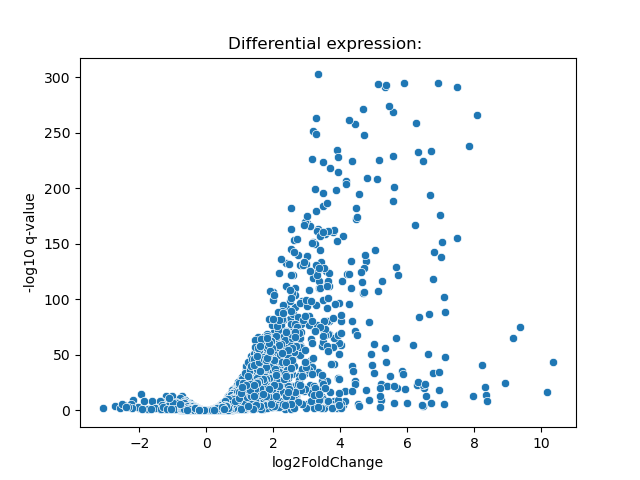

Text(0.5, 1.0, 'Differential expression: ')

In [5]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")
plt.title("Differential expression: ")

Let's subset genes which are highly differentially expressed at 5h p.i. to match the Hi-C dataset.


In [201]:
PADJ_THRESH = 0.05
L2FC_THRESH = 4

<IPython.core.display.Javascript object>


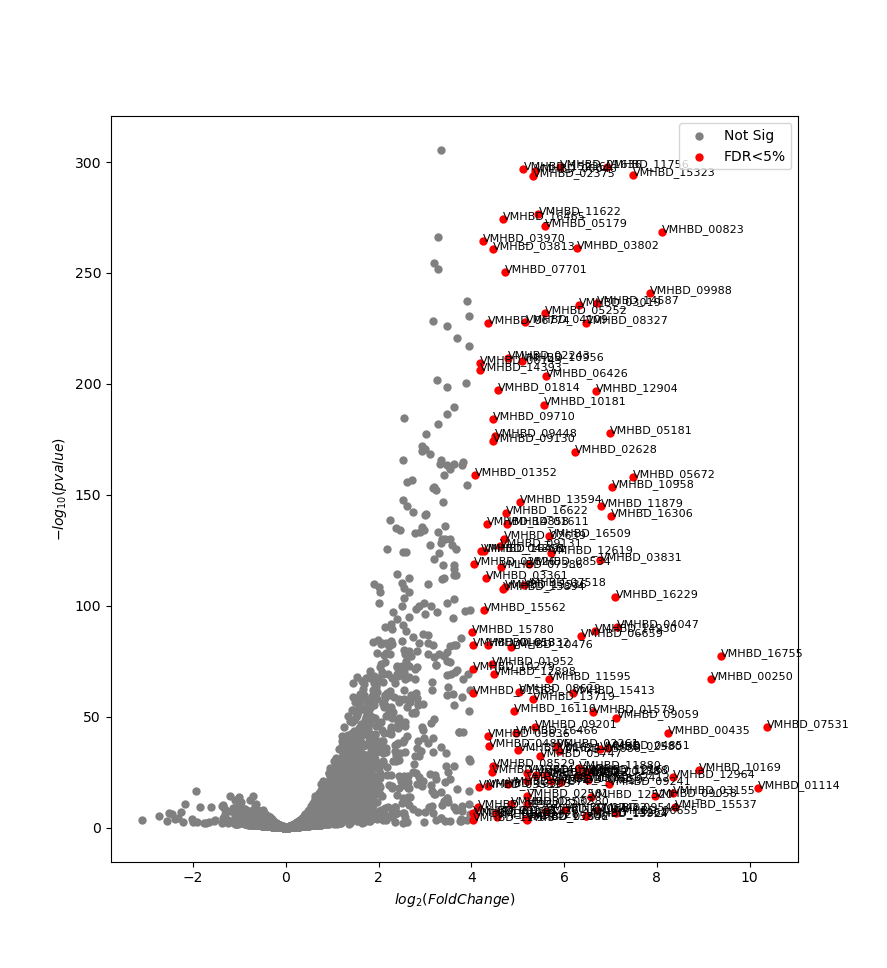

  result = getattr(ufunc, method)(*inputs, **kwargs)



In [202]:
def plot_volcano(data, adjust=False, **kwargs):
    plt.figure(figsize=(7, 10))
    mask = (data['log2FoldChange'].abs() > L2FC_THRESH) & (data['padj'] < PADJ_THRESH)
    xns, yns = data['log2FoldChange'][~mask], -np.log10(data['pvalue'][~mask])
    plt.scatter(xns, yns, c='grey', edgecolor=(1,1,1,0), label='Not Sig')
    xs, ys = data['log2FoldChange'][mask], -np.log10(data['pvalue'][mask])
    plt.scatter(xs, ys, c='r', edgecolor=(1,1,1,0), label='FDR<5%')
    texts = []
    for x, y, l in zip(xs, ys, data['accession'][mask]):
        texts.append(plt.text(x, y, l, size=8))
    plt.legend()
    plt.xlabel('$log_2(Fold Change)$')
    plt.ylabel('$-log_{10}(pvalue)$')
    if adjust:
        plt.title('%s iterations' % adjust_text(texts,
                                                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), **kwargs))
_ = plot_volcano(diff_expr)

In [7]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [182]:
sig_expr

,accession,baseMean,log2FoldChange,lfcSE,pvalue,padj,chrom,type,start,end,attr,length,desc,IPR,PFAM
0,VMHBD_08871,47873.264078,7.954979,0.120793,0.000000,0.000000,scaffold_24,mRNA,875550,878343,ID=VMHBD_08871.mRNA.2;Parent=VMHBD_08871;produ...,2793,hypothetical protein,"[IPR003000, IPR026590, IPR029035, IPR001607, I...","[PF02148, PF02146]"
1,VMHBD_06637,3067.797514,4.945376,0.127112,0.000000,0.000000,scaffold_2,mRNA,1731747,1732987,ID=VMHBD_06637.mRNA.1;Parent=VMHBD_06637;produ...,1240,hypothetical protein,[],[]
2,VMHBD_06241,23666.251237,6.015194,0.126071,0.000000,0.000000,scaffold_2,mRNA,572917,573360,ID=VMHBD_06241.mRNA.1;Parent=VMHBD_06241;produ...,443,hypothetical protein,"[IPR019954, IPR019956, IPR000626, IPR000058, I...","[PF14560, PF11976, PF01428, PF00240]"
3,VMHBD_01577,14663.527464,7.833641,0.155691,0.000000,0.000000,scaffold_11,mRNA,285890,287152,ID=VMHBD_01577.mRNA.1;Parent=VMHBD_01577;produ...,1262,hypothetical protein,[IPR000270],[PF00564]
4,VMHBD_00776,13984.542393,7.319933,0.155868,0.000000,0.000000,scaffold_1,mRNA,1955467,1957466,ID=VMHBD_00776.mRNA.1;Parent=VMHBD_00776;produ...,1999,hypothetical protein,"[IPR002035, IPR032838]","[PF13768, PF14624, PF00092, PF13519]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,VMHBD_05922,4.936595,2.524529,1.562623,0.006818,0.038040,scaffold_19,mRNA,918504,919076,ID=VMHBD_05922.mRNA.1;Parent=VMHBD_05922;produ...,572,hypothetical protein,[],[]
1126,VMHBD_00750,24.658268,-1.244481,0.730112,0.007503,0.041289,scaffold_1,mRNA,1891050,1893929,ID=VMHBD_00750.mRNA.1;Parent=VMHBD_00750;produ...,2879,hypothetical protein,"[IPR001936, IPR008936, IPR013761, IPR001660, I...","[PF00536, PF07647]"
1127,VMHBD_14968,17.248628,1.132976,0.637360,0.008488,0.045702,scaffold_65,mRNA,18310,22168,ID=VMHBD_14968.mRNA.1;Parent=VMHBD_14968;produ...,3858,hypothetical protein,"[IPR008271, IPR001054, IPR011009, IPR000719, I...","[PF07714, PF13458, PF00069]"
1128,VMHBD_02672,21.296171,-1.012098,0.535288,0.008545,0.045947,scaffold_13,mRNA,183666,185211,ID=VMHBD_02672.mRNA.1;Parent=VMHBD_02672;produ...,1545,hypothetical protein,[],[]


In [9]:
sig_expr = sig_expr.merge(annot, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [10]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 1130 genes (6.69%)  with more than 1 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, the homologous gene in our assembly is VMHBD_08871. Let's have a look at these.

In [11]:
sig_expr.loc[sig_expr.accession ==  'VMHBD_08871', :]

,accession,baseMean,log2FoldChange,lfcSE,pvalue,padj,chrom,type,start,end,attr,length,desc,IPR,PFAM
0,VMHBD_08871,47873.264078,7.954979,0.120793,0.0,0.0,scaffold_24,mRNA,875550,878343,ID=VMHBD_08871.mRNA.2;Parent=VMHBD_08871;produ...,2793,hypothetical protein,"[IPR003000, IPR026590, IPR029035, IPR001607, I...","[PF02148, PF02146]"


It is indeed in our top differentially expressed gene list. 

For the next, preliminary analyses I will work with a subset of genes to avoid blowing up memory.

In [12]:
sub_genes = annot.sample(1000)

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.

> Note: All this will be done on the normalized and detrended matrix to correct for accessibility and genomic distance.

In [13]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/sub_uninfected.mcool::/resolutions/2000')
clr_inf = cooler.Cooler('data/output/cool/sub_infected.mcool::/resolutions/2000')

In [32]:
import itertools as it
import subprocess as sp
import tempfile
import shlex

def run_command(cmd: str):
    p = sp.Popen(shlex.split(cmd), bufsize=1, universal_newlines=True)
    return p.poll()

def get_contact_gene_pairs(cool_path: str, genes: pd.DataFrame, winsize=7, intra=False) -> pd.DataFrame:
    """
    Compute contacts between all gene pairs.
    genes must have columns: chrom start end accession
    """
    # Generate all pairwise gene combinations and save as bed2d
    tmp_bed = tempfile.NamedTemporaryFile(delete=False)
    
    if intra:
        combs = []
        for chrom in cooler.Cooler(cool_path).chroms()[:]['name']:
            combs += list(it.combinations(genes.accession[genes.chrom==chrom], 2))
        combs = pd.DataFrame((combs))
    else:
        combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')    
    combs = combs.loc[:, ['chrom_x', 'start_x', 'end_x', 'chrom_y', 'start_y', 'end_y']]
    combs.to_csv(tmp_bed.name, sep='\t', header=False, index=False)
    
    # Run chromosight to extract windows of the Hi-C matrix at each inter-gene coordinate
    with tempfile.TemporaryDirectory() as chromo_dir:
        cmd = f'chromosight quantify --win-fmt=npy -t12 -u100 -z100 -I -W{winsize} {tmp_bed.name} {cool_path} {chromo_dir}/curr'
        !{cmd} # jupyter syntax. In regular python script use run_command function instead
    
        # Retrieve windows. We don't actually care about scores
        wins = np.load(chromo_dir + "/curr.npy")
        coords = pd.read_csv(chromo_dir + "/curr.tsv", sep='\t', usecols=range(6))
    
    # Annotate chromosight output with gene accessions
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('1'),
        on=['chrom1', 'start1', 'end1'],
        how='left',
    )
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('2'),
        on=['chrom2', 'start2', 'end2'],
        how='left',
    )
    # For each gene pair, add the mean contact value in the window as a column
    coords['mean_contacts'] = np.nansum(np.nansum(wins, axis=1), axis=1)/(wins.shape[0] * wins.shape[1])
    
    return coords

Now I use chromosight to compute normalized + detrended contacts between all pairs of genes.

In [33]:
p_hic = get_contact_gene_pairs('data/output/cool/sub_uninfected.mcool::/resolutions/2000', sub_genes)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs('data/output/cool/sub_infected.mcool::/resolutions/2000', sub_genes)['mean_contacts']


Matrix already balanced, reusing weights
Found 21955 / 22100 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpo2ozfeh5/curr.pdf
Matrix already balanced, reusing weights
Found 21927 / 22100 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpcc1dibz7/curr.pdf


When visualising the results, it seems that genes differentially expressed at 8h p.i. do not have stronger contacts change during infection than the rest of the genome. The histogram below shows the proportion of contact change during infection (5h pi).

> Note: Only gene pairs where both genes have nonzero contacts in both conditions (uninfected or infected) were shown.

In [34]:
p_hic.head()

,chrom1,start1,end1,chrom2,start2,end2,accession1,accession2,ctl_contacts,inf_contacts
0,scaffold_1,150825,152515,scaffold_1,161941,164737,VMHBD_00055,VMHBD_00059,0.000011,0.000007
1,scaffold_1,150825,152515,scaffold_1,243261,250019,VMHBD_00055,VMHBD_00094,0.000010,0.000009
2,scaffold_1,150825,152515,scaffold_1,289715,290356,VMHBD_00055,VMHBD_00110,0.000012,0.000012
3,scaffold_1,150825,152515,scaffold_1,303305,304535,VMHBD_00055,VMHBD_00115,0.000006,0.000008
4,scaffold_1,150825,152515,scaffold_1,357354,360054,VMHBD_00055,VMHBD_00142,0.000006,0.000012


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


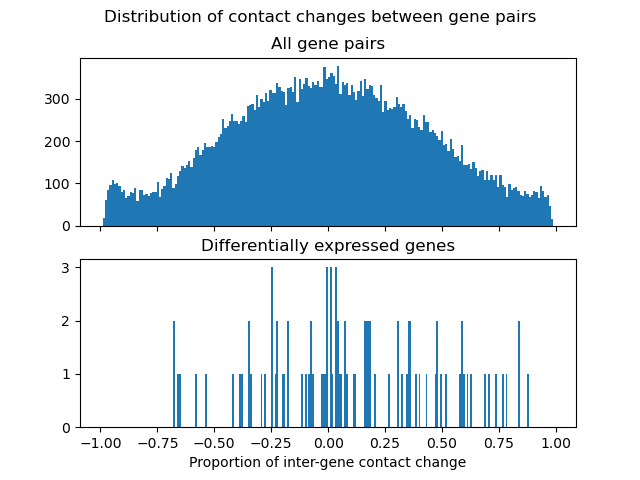

Text(0.5, 0, 'Proportion of inter-gene contact change')

In [35]:
%matplotlib notebook
de_nnz_hic = p_hic.loc[
    p_hic.accession1.isin(sig_expr.accession) &
    p_hic.accession2.isin(sig_expr.accession) &
    (p_hic.inf_contacts > 0) &
    (p_hic.ctl_contacts > 0),
    :
]
de_nnz_hic.prop_change = (de_nnz_hic.inf_contacts - de_nnz_hic.ctl_contacts) / (de_nnz_hic.inf_contacts + de_nnz_hic.ctl_contacts)

nnz_hic = p_hic.loc[(p_hic.ctl_contacts > 0) & (p_hic.inf_contacts) > 0, :]
nnz_hic.prop_change = (nnz_hic.inf_contacts - nnz_hic.ctl_contacts) / (nnz_hic.inf_contacts + nnz_hic.ctl_contacts)

fig, ax = plt.subplots(2, 1, sharex=True)
f = ax[0].hist(
    (nnz_hic.prop_change),
    200
)
f = ax[1].hist(
    (de_nnz_hic.prop_change),
    200
)


plt.suptitle("Distribution of contact changes between gene pairs")
ax[0].set_title("All gene pairs")
ax[1].set_title("Differentially expressed genes")
ax[1].set_xlabel('Proportion of inter-gene contact change')

In [36]:
print(
    f'The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : {ss.mannwhitneyu(abs(nnz_hic.prop_change), abs(de_nnz_hic.prop_change))}'
)

The differentially expressed do not have significantly stronger contact changes than the rest of the genome. Mann whitney U : MannwhitneyuResult(statistic=1639861.0, pvalue=0.02056713070275002)


In [37]:
nnz_gene_pairs = nnz_hic.shape[0]
nnz_inter_pairs = nnz_hic.loc[nnz_hic.chrom1 != nnz_hic.chrom2, :].shape[0]
print(f'There are {nnz_gene_pairs} gene pairs with nonzero contacts (out of {p_hic.shape[0]}).'
      f' {nnz_inter_pairs} of these are interchromosomal'
)

There are 40652 gene pairs with nonzero contacts (out of 499500). 38325 of these are interchromosomal


When visualizing the pairwise gene-gene contact matrix, we see clusters appearing along the diagonal.
This confirms that genes closer to each other make more contacts with each other (after detrending for diagonal gradient). This suggest they are involved in some sort of contact domains

In [38]:
p_hic

,chrom1,start1,end1,chrom2,start2,end2,accession1,accession2,ctl_contacts,inf_contacts
0,scaffold_1,150825,152515,scaffold_1,161941,164737,VMHBD_00055,VMHBD_00059,0.000011,0.000007
1,scaffold_1,150825,152515,scaffold_1,243261,250019,VMHBD_00055,VMHBD_00094,0.000010,0.000009
2,scaffold_1,150825,152515,scaffold_1,289715,290356,VMHBD_00055,VMHBD_00110,0.000012,0.000012
3,scaffold_1,150825,152515,scaffold_1,303305,304535,VMHBD_00055,VMHBD_00115,0.000006,0.000008
4,scaffold_1,150825,152515,scaffold_1,357354,360054,VMHBD_00055,VMHBD_00142,0.000006,0.000012
...,...,...,...,...,...,...,...,...,...,...
499495,scaffold_57,17553,19296,scaffold_54,21207,22189,VMHBD_14310,VMHBD_14273,0.000000,0.000000
499496,scaffold_55,678,2071,scaffold_54,21207,22189,VMHBD_14279,VMHBD_14273,0.000000,0.000000
499497,scaffold_41,4654,5832,scaffold_54,21207,22189,VMHBD_13436,VMHBD_14273,0.000000,0.000000
499498,scaffold_71,1741,2535,scaffold_54,21207,22189,VMHBD_15589,VMHBD_14273,0.000000,0.000000


<IPython.core.display.Javascript object>


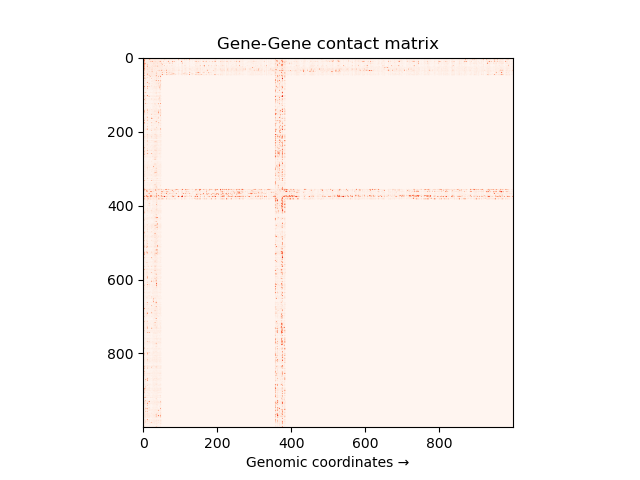

Text(0.5, 0, 'Genomic coordinates →')

In [39]:
%matplotlib notebook
hic_mat = p_hic.sort_values(['chrom1', 'chrom2', 'start1', 'start2']).loc[:, ['accession1', 'accession2', 'ctl_contacts']].pivot('accession1', 'accession2').fillna(0)
hic_mat.columns = [o[1] for o in hic_mat.columns]
ord_genes = [g for g in annot.sort_values(['chrom', 'start']).accession if g in hic_mat.columns]
hic_mat = hic_mat.loc[ord_genes, :].loc[:, ord_genes]
hic_mat = hic_mat.to_numpy() + hic_mat.to_numpy().T
plt.imshow(np.log1p(hic_mat), vmax = np.percentile(hic_mat, 99.8), cmap='Reds')
plt.title('Gene-Gene contact matrix')
plt.xlabel('Genomic coordinates →')

We can also visualize the detrended contacts vs genomic distance plot, showing a contact enrichment between pairs of genes spaced by ~10kb.

<IPython.core.display.Javascript object>


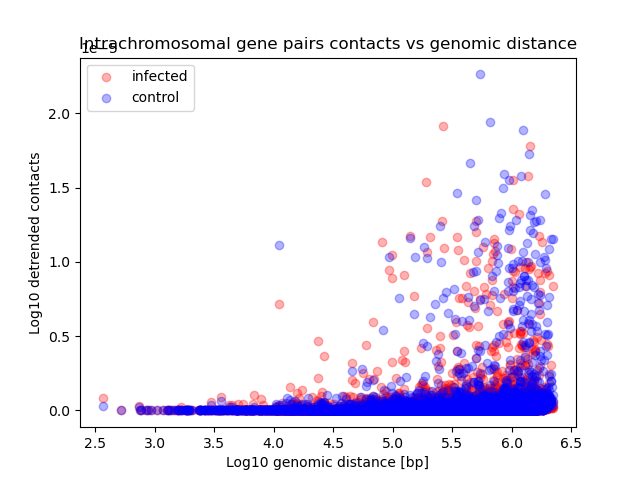

In [40]:
%matplotlib notebook
cis_hic = p_hic.loc[p_hic.chrom1 == p_hic.chrom2, :]
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.inf_contacts, c='red', alpha=0.3, label='infected')
plt.scatter(np.log10(abs(cis_hic.start2 - cis_hic.start1)), cis_hic.ctl_contacts, c='blue', alpha=0.3, label='control')
plt.title("Intrachromosomal gene pairs contacts vs genomic distance")
plt.ylabel("Log10 detrended contacts")
plt.xlabel("Log10 genomic distance [bp]")
plt.legend()

## Infection vs chromatin loops

The genome of _A. castellanii_ is spanned by numerous regularly spaced chromatin loops. Are they linked to gene expression ?

In [135]:
loops = pd.read_csv('data/output/chromosight/merged_contacts/loops_out.tsv', sep='\t')
anchors = (
    pd.concat([
        loops[['chrom1', 'start1', 'end1', 'score']].rename(columns=lambda x: re.sub('1$','', x)),
        loops[['chrom2', 'start2', 'end2', 'score']].rename(columns=lambda x: re.sub('2$', '', x)),
    ])
    .sort_values(['chrom', 'start', 'score'])
    .drop_duplicates(subset=['chrom', 'start', 'end'])
    .reset_index(drop=True)
    .rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'})
)

In [140]:
import pyranges as pr
annot_pr = pr.PyRanges(annot.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'}))
loops_pr = pr.PyRanges(anchors)
expr_dist = (
    loops_pr
    .nearest(annot_pr)
    .df
    .loc[:, ['accession', 'Distance', 'score']]
    .merge(diff_expr[['accession', 'baseMean', 'log2FoldChange', 'pvalue']])
    .dropna()
)
no_loop = expr_dist.Distance > 0

Genes on a chromatin loop anchor are more strongly expressed on average and more differentially expressed during infection. This may suggest that loops occur both at house-keeping genes which are generally stable and strongly expressed, and genes that change during infection (of potential regulatory importance).

<IPython.core.display.Javascript object>


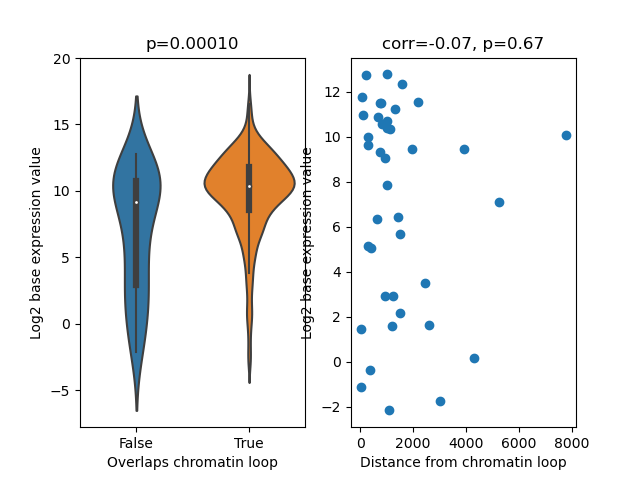

  FutureWarning



Text(0.5, 1.0, 'corr=-0.07, p=0.67')

In [114]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)
sns.violinplot(~no_loop, np.log2(expr_dist.baseMean), ax=ax[0])
ax[0].set_xlabel('Overlaps chromatin loop')
ax[0].set_ylabel('Log2 base expression value')
stat = ss.mannwhitneyu(np.log2(expr_dist.baseMean[~no_loop]), np.log2(expr_dist.baseMean[no_loop]))
ax[0].set_title(f'p={stat[1]:.5f}')
ax[1].scatter(expr_dist.Distance[no_loop], np.log2(expr_dist.baseMean[no_loop]))
ax[1].set_xlabel("Distance from chromatin loop")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.pearsonr(expr_dist.Distance[no_loop], np.log2(expr_dist.baseMean[no_loop]))
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


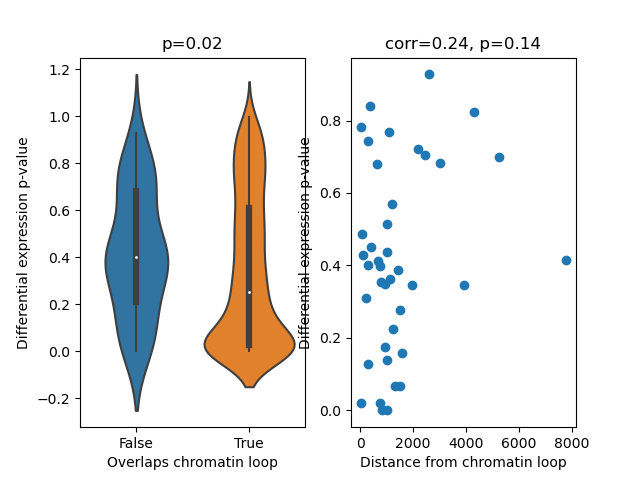

  FutureWarning



Text(0.5, 1.0, 'corr=0.24, p=0.14')

In [168]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)
sns.violinplot(~no_loop, expr_dist.pvalue, ax=ax[0])
ax[0].set_xlabel('Overlaps chromatin loop')
ax[0].set_ylabel('Differential expression p-value')
stat = ss.mannwhitneyu(expr_dist.pvalue[~no_loop], expr_dist.pvalue[no_loop])
ax[0].set_title(f'p={stat[1]:.2f}')
ax[1].scatter(expr_dist.Distance[no_loop], expr_dist.pvalue[no_loop])
ax[1].set_xlabel("Distance from chromatin loop")
ax[1].set_ylabel("Differential expression p-value")
corr = ss.pearsonr(expr_dist.Distance[no_loop], expr_dist.pvalue[no_loop])
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

<IPython.core.display.Javascript object>


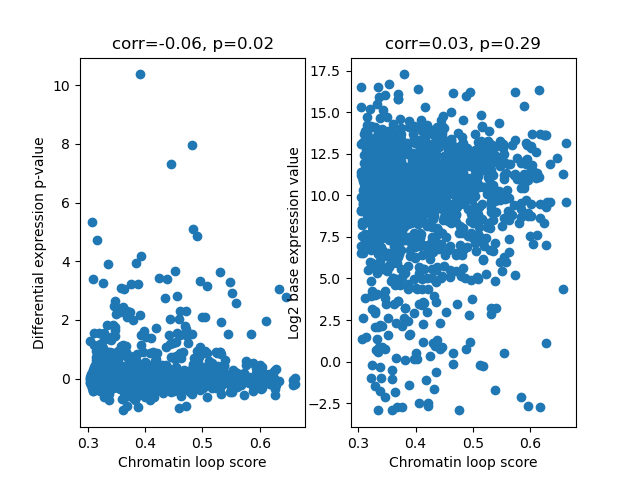

Text(0.5, 1.0, 'corr=0.03, p=0.29')

In [169]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

ax[0].scatter(expr_dist.score, expr_dist.pvalue)
ax[0].set_xlabel("Chromatin loop score")
ax[0].set_ylabel("Differential expression p-value")
corr = ss.pearsonr(expr_dist.score, expr_dist.pvalue)
ax[0].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

ax[1].scatter(expr_dist.score, np.log2(expr_dist.baseMean))
ax[1].set_xlabel("Chromatin loop score")
ax[1].set_ylabel("Log2 base expression value")
corr = ss.pearsonr(expr_dist.score, np.log2(expr_dist.baseMean))
ax[1].set_title(f'corr={corr[0]:.2f}, p={corr[1]:.2f}')

### SImple DE analysis
Instead of using all 4 timepoints and working with pairs of genes, here I try a simpler path.
For each gene, I just use the highest contact value (most frequently interacting neighbour).
I then compare this change in interaction during infection (5h vs uninfected) with the differential expression at 8h p.i. (vs 0)

In [108]:
# Get the mate gene with highest contacts for each gene
high_val = hic_mat.max(axis=0)
high_mate = np.array(ord_genes)[hic_mat.argmax(axis=0)]
dc = pd.DataFrame({'accession': ord_genes, 'mate': high_mate})

# Extract the upper triangle matrix
lower = p_hic.accession2 < p_hic.accession1
full_hic = p_hic.loc[:, ['accession1', 'accession2', 'ctl_contacts', 'inf_contacts']]
full_hic.loc[
    lower, ['accession1', 'accession2']
] = full_hic.loc[
    lower, ['accession2', 'accession1']
].values

# Extract contact values for best-mate pairs
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession1', 'accession2'], how='left').drop(columns=['accession1', 'accession2'])
dc = dc.merge(full_hic, left_on=['accession', 'mate'], right_on=['accession2', 'accession1'], how='left').drop(columns=['accession1', 'accession2'])
dc.ctl_contacts_x[dc.ctl_contacts_x.isnull()] = dc.ctl_contacts_y[dc.ctl_contacts_x.isnull()]
dc.inf_contacts_x[dc.inf_contacts_x.isnull()] = dc.inf_contacts_y[dc.inf_contacts_x.isnull()]
dc = dc.drop(
    columns=['inf_contacts_y', 'ctl_contacts_y']
).rename(
    columns={'ctl_contacts_x': 'ctl_contacts', 'inf_contacts_x': 'inf_contacts'}
)
dc = dc.merge(diff_expr, on='accession', how='inner')
dc = dc.dropna()
dc['prop_change'] = (dc['inf_contacts'] - dc['ctl_contacts']) / (dc['inf_contacts'] + dc['ctl_contacts'])
# add chromosomal coordinates of genes
dc = dc.merge(annot.loc[:, ['chrom', 'start', 'end', 'accession']], on='accession', how='left')

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


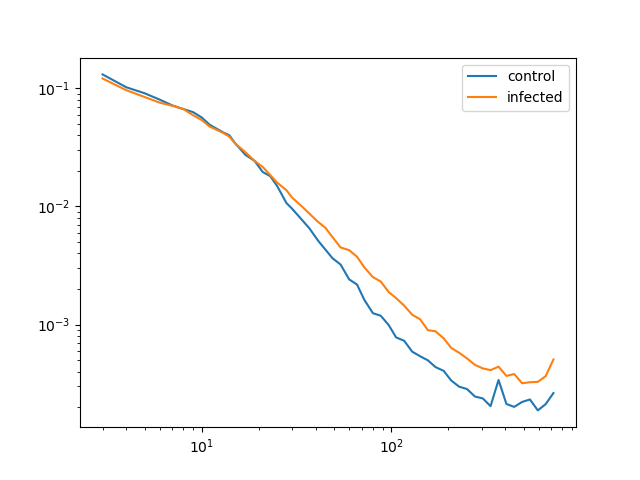

In [109]:
%matplotlib notebook
from hicstuff.hicstuff import distance_law_from_mat
x_ctl, y_ctl = distance_law_from_mat(clr_ctl.matrix(sparse=True, balance=False).fetch('scaffold_4'))
x_inf, y_inf = distance_law_from_mat(clr_inf.matrix(sparse=True, balance=False).fetch('scaffold_4'))
first = 3
x_ctl = x_ctl[first:]
y_ctl = y_ctl[first:]
x_inf = x_inf[first:]
y_inf = y_inf[first:]
plt.loglog(x_ctl, y_ctl/np.sum(y_ctl), label='control')
plt.loglog(x_inf, y_inf/np.sum(y_inf), label='infected')
plt.legend()


In [110]:
dc

,accession,mate,ctl_contacts,inf_contacts,baseMean,log2FoldChange,lfcSE,pvalue,padj,prop_change,chrom,start,end
0,VMHBD_00055,VMHBD_04273,0.000017,1.224822e-06,14002.089900,-0.160098,0.107376,0.127807,0.344362,-0.868257,scaffold_1,150825,152515
1,VMHBD_00059,VMHBD_00442,0.000016,4.536199e-07,2033.184033,-0.125726,0.107927,0.232534,0.494586,-0.943189,scaffold_1,161941,164737
2,VMHBD_00094,VMHBD_00558,0.000016,5.358170e-06,94.276815,-0.950721,0.269764,0.000092,0.000794,-0.493658,scaffold_1,243261,250019
3,VMHBD_00110,VMHBD_08072,0.000015,4.749793e-07,530.298379,-0.075068,0.177506,0.652557,0.843132,-0.939246,scaffold_1,289715,290356
4,VMHBD_00115,VMHBD_11991,0.000014,2.973720e-07,6502.679028,0.151653,0.116726,0.183390,0.429091,-0.959412,scaffold_1,303305,304535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,VMHBD_16817,VMHBD_00055,0.000000,0.000000e+00,1614.262161,0.285934,0.146265,0.041731,0.159025,NaN,scaffold_9,1350925,1352769
959,VMHBD_16818,VMHBD_06211,0.000004,5.192432e-07,5346.208558,-0.091798,0.115114,0.413266,0.678111,-0.772769,scaffold_9,1353713,1356095
960,VMHBD_16829,VMHBD_00110,0.000007,3.069183e-06,5123.922016,-0.022676,0.144065,0.864005,0.944947,-0.408243,scaffold_9,1377984,1379231
961,VMHBD_16852,VMHBD_00704,0.000001,4.376508e-07,6807.048414,-0.273548,0.115017,0.014656,0.070992,-0.523009,scaffold_9,1439868,1441786



### Border change vs expression

Here, I check if gene expression changes are associated with changes in the intensity of the closest domain border.

In [170]:
# Use asof merge borders and differential contacts dataframes to assign the closest border to each gene
borders = pd.read_csv('data/output/pareidolia/borders_change_infection_time.tsv', sep='\t')
dc = pd.merge_asof(
    dc.sort_values('start'),
    borders.loc[:, ['chrom1', 'start1', 'diff_score']].sort_values('start1'),
    left_by='chrom',
    left_on='start',
    right_by='chrom1',
    right_on='start1'
)


  FutureWarning



<IPython.core.display.Javascript object>


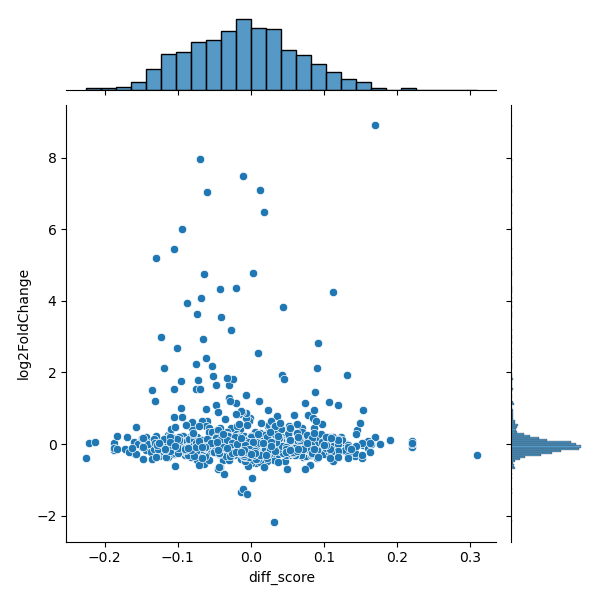

In [181]:
%matplotlib notebook
sns.jointplot(dc.diff_score, dc.log2FoldChange)